<img src="https://chnet-000.fi.infn.it/assets/images/EOSc-Pillar_logo_color.png"/>

# How to re-use trained Inpainting Model

Here we import the trained model on 32x32 images, and apply it to some examples to show how it performs. 

We will need some ancillary function to use it properly, namely some function to create the damage mask as well as some functions to resize/crop the images.

<img src="https://chnet-000.fi.infn.it/assets/images/Logo_INFN_CHNet_esteso.png" style="width: 250px; float: right;"/>

In [1]:
import os 
import cv2
import numpy as np
import pandas as pd

from PIL import Image, ImageOps 

import keras

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid

from PIL import Image, ImageOps
import skimage as sk
from skimage import io as sk_io
from skimage.filters import threshold_otsu
from skimage import transform as sk_transform

## 1. Defining custom ancillary functions

We need to define here few ancillary functions which help us in resize/crop/adjust functions, and show them

In [2]:
#################################################
# Ancillary functions

print('DEFINING THE show_images FUNCTION \n')

def show_images(images, fig_size=(12,12)):
    # Set up a figure of an appropriate size
    fig = plt.figure(figsize=fig_size)

    image_num = 0
    num_images = len(images)
    # loop through the images
    for image_idx in range(num_images):
        # Keep an incrementing count of each image
        a=fig.add_subplot(1, num_images, image_idx+1)
        # Add the image to the plot
        image_plot = plt.imshow(images[image_idx])
        # Add a caption with the folder name
        a.set_title("Image " + str(image_idx+1))

    # Show the plot
    plt.show()
    
print('DEFINING THE resize_image FUNCTION \n')

def resize_image(src_image, size=(32,32), bg_color="white"): # the 2° and 3° entries are setted by default, so they can be either called or not.
    from PIL import Image, ImageOps 
    
    # resize the image so the longest dimension matches our target size
    src_image.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new square background image
    new_image = Image.new("RGB", size, bg_color)
    
    # Paste the resized image into the center of the square background
    new_image.paste(src_image, (int((size[0] - src_image.size[0]) / 2), int((size[1] - src_image.size[1]) / 2)))
  
    # return the resized image
    return new_image

print('DEFINING THE resize_image_with_cut FUNCTION \n') # from https://note.nkmk.me/en/python-pillow-square-circle-thumbnail/

def crop_center(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

def crop_max_square(pil_img):
    return crop_center(pil_img, min(pil_img.size), min(pil_img.size))

def resize_image_to_square_with_cut(src_image, size=32, bg_color="white"): # the 2° and 3° entries are setted by default, so they can be either called or not.
    from PIL import Image, ImageOps 
    
    im = src_image
    width, height = im.size 
    
    if width > height:
        new_image = crop_max_square(im)
    elif width < height:
        new_image = crop_max_square(im)
    elif width == height:
        new_image = resize_image(im, size = (size, size), bg_color = bg_color)
  
    # return the resized image
    return new_image


DEFINING THE show_images FUNCTION 

DEFINING THE resize_image FUNCTION 

DEFINING THE resize_image_with_cut FUNCTION 



## 2. Importing the model

In order to import the model, we need to redefine the metric we defined in the training 

In [3]:
## Metric
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [4]:
################################################################
# IMPORTING MODEL 
# https://www.tensorflow.org/guide/keras/save_and_serialize
################################################################
path_to_import_model = 'Model_data/model_v2020-10-30-09-38-13.h5'

dependencies = {
    'dice_coef': dice_coef
}


reconstructed_model = keras.models.load_model(path_to_import_model, custom_objects=dependencies)

## 3. Create damage mask classes

Here we define tree classes which will apply a damage mask to our images. 

1. Segments; it insert a random numbers of segments whose thickness and endpoints are randomly generated. 
2. Disks: it defines a random number of disks with random radius inserted at a random point on the image;

In [5]:
#############################
# Segment
class createAugmentSegment(keras.utils.Sequence):
    def __init__(self, X, y, batch_size=32, dim=(32, 32), n_channels=3, shuffle=True):
        'Initialization'
        self.batch_size = batch_size 
        self.X, self.y = X, y
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        
        # Parametri di danneggiamento
        self.N_damage = 6;
        self.thickness_damage = 3;
      
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        return self.__data_generation(indexes)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, idxs):
        # X_batch is a matrix of masked images used as input
        X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
        # y_batch is a matrix of original images used for computing error from reconstructed image
        y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image

        ## Iterate through random indexes
        for i, idx in enumerate(idxs):
            image_copy = self.X[idx].copy()

            ## Get mask associated to that image
            masked_image = self.__createMask(image_copy)
            
            # Data Normalization -> image from (0, 255) to (0., 1.)
            X_batch[i,] = masked_image/255
            y_batch[i] = self.y[idx]/255

        return X_batch, y_batch

    def __createMask(self, img):
        ## Prepare masking matrix
        mask = np.full((self.dim[0], self.dim[1], 3), 255, np.uint8)
        
        for _ in range(np.random.randint(1, self.N_damage)):
            # Get random x locations to start line
            x1, x2 = np.random.randint(1, self.dim[0]), np.random.randint(1, self.dim[0])
            # Get random y locations to start line
            y1, y2 = np.random.randint(1, self.dim[1]), np.random.randint(1, self.dim[1])
            # Get random thickness of the line drawn
            thickness = np.random.randint(2, self.thickness_damage)
            # Draw black line on the white mask
            cv2.line(mask,(x1,y1),(x2,y2),(1,1,1),thickness)

        # Perforn bitwise "and" operation to mak the image
        masked_image = cv2.bitwise_and(img, mask)

        return masked_image

In [6]:
################################
# Disk Damage
class createAugmentDisks(keras.utils.Sequence):
    def __init__(self, X, y, batch_size=32, dim=(32, 32), n_channels=3, shuffle=True):
        'Initialization'
        self.batch_size = batch_size 
        self.X, self.y = X, y
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        
        # Parametri di danneggiamento
        self.N_damage = 10;
        self.thickness_damage = 5;
      
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        return self.__data_generation(indexes)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, idxs):
        # X_batch is a matrix of masked images used as input
        X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
        # y_batch is a matrix of original images used for computing error from reconstructed image
        y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image

        ## Iterate through random indexes
        for i, idx in enumerate(idxs):
            image_copy = self.X[idx].copy()

            ## Get mask associated to that image
            masked_image = self.__createMask(image_copy)
            
            # Data Normalization -> image from (0, 255) to (0., 1.)
            X_batch[i,] = masked_image/255
            y_batch[i] = self.y[idx]/255

        return X_batch, y_batch

    def __createMask(self, img):
        ## Prepare masking matrix
        mask = np.full((self.dim[0], self.dim[1], 3), 255, np.uint8)
        
        for _ in range(np.random.randint(2, self.N_damage)):
            # Get random center location 
            x1, y1 = np.random.randint(1, self.dim[0]), np.random.randint(1, self.dim[1])
            # Get random radius of the circle drawn
            radius = np.random.randint(1, self.thickness_damage)
            # Tjickness set to -1 to fill the circle
            thickness = -1 
            # Draw black circle on the white mask
            # cv2.circle(image, center_coordinates, radius, color, thickness)  --> https://www.geeksforgeeks.org/python-opencv-cv2-circle-method/
            cv2.circle(mask, (x1,y1), radius, (1,1,1), thickness)

        # Perforn bitwise "and" operation to mak the image
        masked_image = cv2.bitwise_and(img, mask)

        return masked_image

## 4. Importing images

Here we import and customize the images

Imported Images


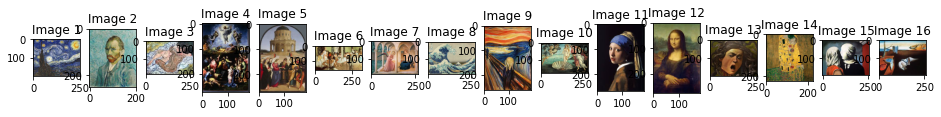

Resized Images


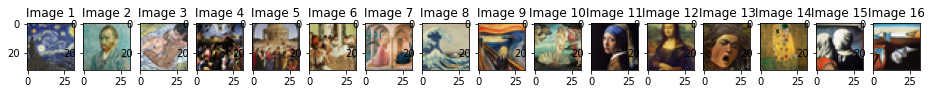

In [7]:
print('Imported Images')

path_to_folder = 'images/numbered_imgs/'

images = []
_path, _dirs, _files = next(os.walk(path_to_folder))

for file in _files:
    img = Image.open(path_to_folder + file)
    images.append(img)

fig_size=(16,16)
show_images(images, fig_size=fig_size)
    
print('Resized Images')

resized_images = []
for image in images:
    image = crop_max_square(image)
    image = resize_image(image, size=(32,32), bg_color='black')
    resized_images.append(image)

show_images(resized_images, fig_size=fig_size)

## 5. Application of the Neural Network and Transfer Learning

We will apply the trained CNN to 2 different types of artificial damages. The first one, the Segments, is the same on which the neural network was trained; the other two are "new damages".

This will show a simple example of transfer learning. 

We will note that the CNN is deep enough to actually perform well on the damaged images, even in different cases.

### 5.1. Segments

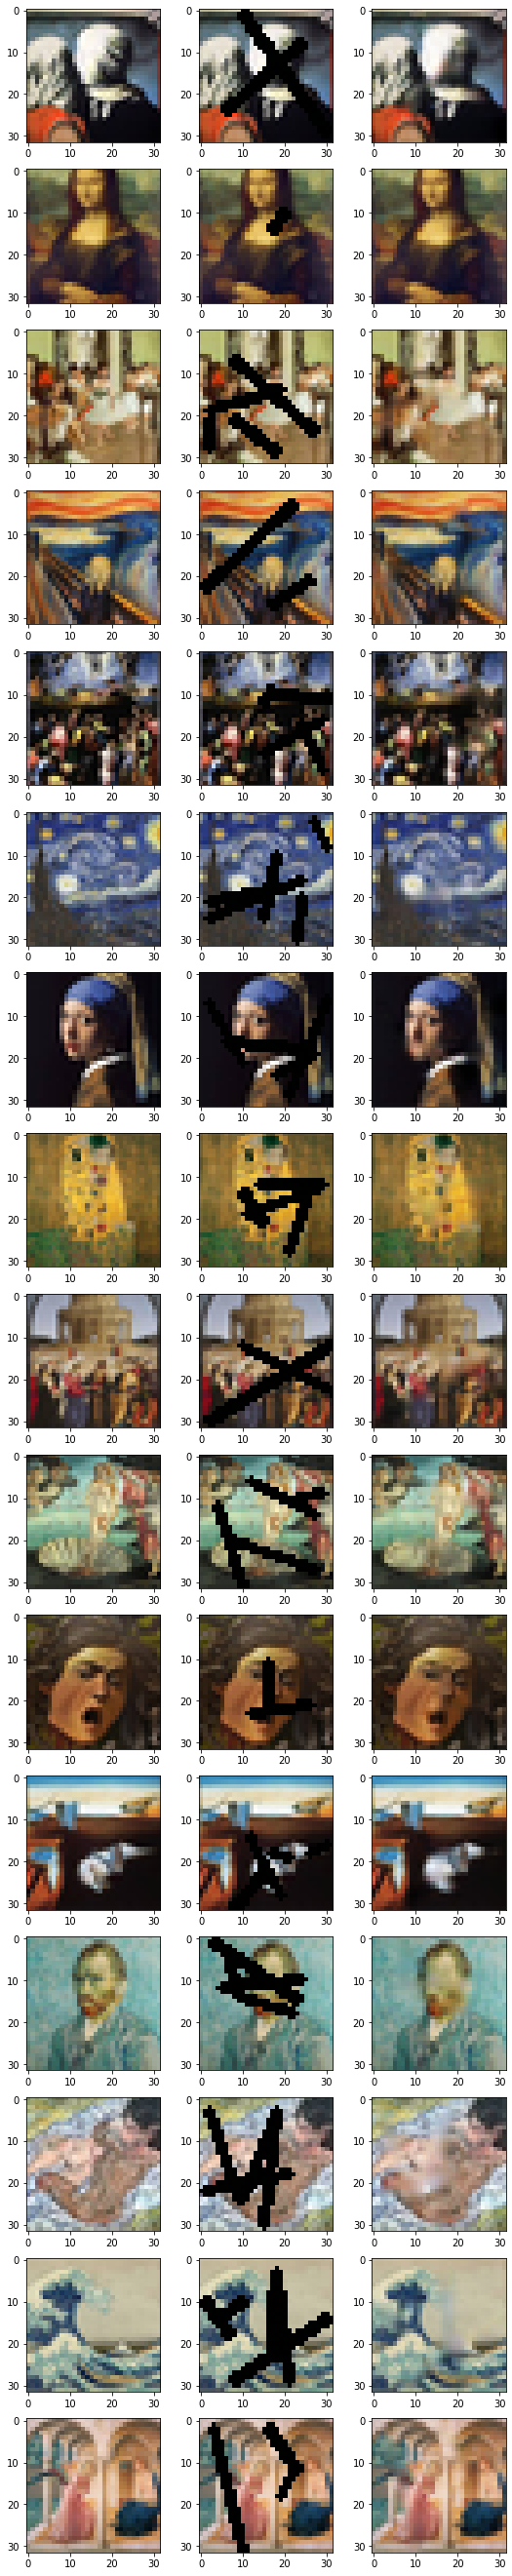

In [8]:
final_images = []
for image in resized_images:
    final_images.append(np.array(image))

finaltest = createAugmentSegment(final_images, final_images, dim=(32,32))

rows = len(final_images)
sample_images, sample_labels = finaltest[0]

fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(9, 3*rows))

for i in range(rows):
    impainted_image = reconstructed_model.predict(sample_images[i].reshape((1,)+sample_images[i].shape))
    axs[i][0].imshow(sample_labels[i])
    axs[i][1].imshow(sample_images[i])
    axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))

plt.show()

### 5.2. Disks

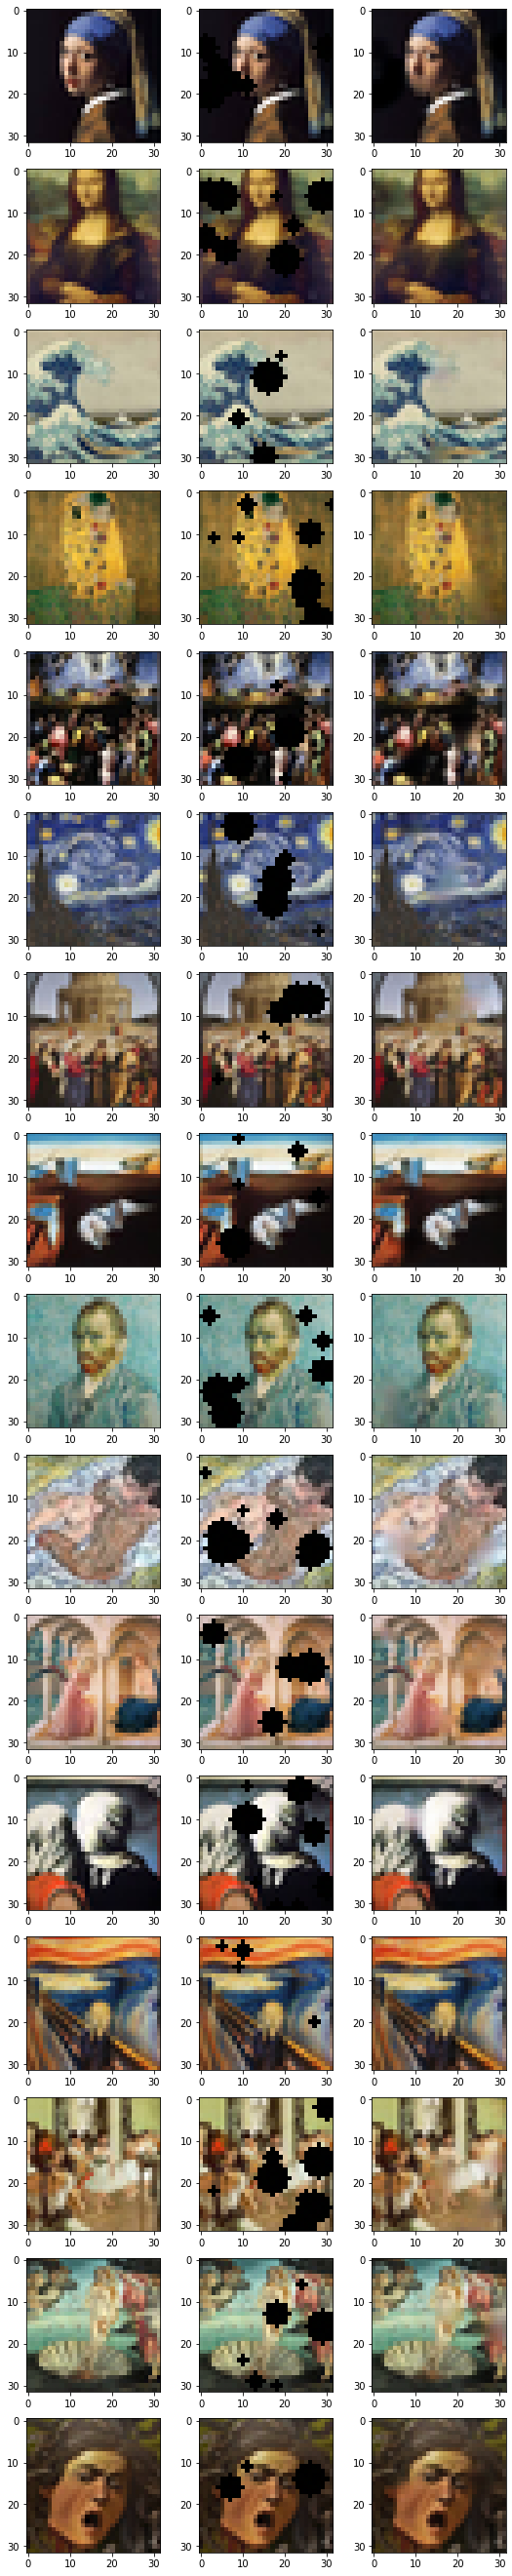

In [9]:
final_images = []
for image in resized_images:
    final_images.append(np.array(image))

finaltest = createAugmentDisks(final_images, final_images, dim=(32,32))

rows = len(final_images)
sample_images, sample_labels = finaltest[0]

fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(9, 3*rows))

for i in range(rows):
    impainted_image = reconstructed_model.predict(sample_images[i].reshape((1,)+sample_images[i].shape))
    axs[i][0].imshow(sample_labels[i])
    axs[i][1].imshow(sample_images[i])
    axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))

plt.show()

<img src="https://chnet-000.fi.infn.it/assets/images/Logo_INFN_CHNet_esteso.png" width="400px"/>

<img src="https://gitlab.com/alessandro.bombini.fi/image-inpainting-tutorial/-/raw/master/pics/EOSc-Pillar_logo_final_Squared.png"/>